
# DBSCAN y HDBSCAN


## Introducción
Crearemos dos modelos de agrupamiento utilizando datos recopilados por StatCan, que contienen los nombres, tipos y ubicaciones de instalaciones culturales y artísticas en todo Canadá. Nos centraremos en las ubicaciones de los museos distribuidos por el país.

#### Fuente de datos: Base de Datos Abierta de Instalaciones Culturales y Artísticas (ODCAF)
Se trata de un conjunto de datos abiertos que incluye los nombres, tipos y ubicaciones de instalaciones culturales y artísticas en Canadá. Está publicado bajo la Licencia de Gobierno Abierto - Canadá. Los distintos tipos de instalaciones están etiquetados bajo el campo 'ODCAF_Facility_Type'.

#### Página web
https://www.statcan.gc.ca/en/lode/databases/odcaf

#### link para descargar el archivo zip
https://www150.statcan.gc.ca/n1/en/pub/21-26-0001/2020001/ODCAF_V1.0.zip?st=brOCT3Ry


In [62]:
# Instalamos la librería 'contextily', que permite añadir mapas base (como fondos geográficos) en visualizaciones con datos espaciales
!pip install contextily

In [63]:
# Importamos las librerías necesarias
import numpy as np  # Para operaciones numéricas
import pandas as pd  # Para manipulación de datos en formato tabla (DataFrames)
import matplotlib.pyplot as plt  # Para generar gráficos

# Algoritmos de agrupamiento
from sklearn.cluster import DBSCAN  # Algoritmo de agrupamiento basado en densidad
import hdbscan  # Variante más avanzada de DBSCAN

# Para escalar los datos antes de aplicar los algoritmos
from sklearn.preprocessing import StandardScaler

# Herramientas geográficas
import geopandas as gpd  # Extensión de pandas para trabajar con datos geoespaciales
import contextily as ctx  # Para añadir mapas base (tiles) como fondo geográfico
from shapely.geometry import Point  # Para crear objetos geométricos tipo punto

# Ignoramos las advertencias para evitar que se muestren en la salida
import warnings
warnings.filterwarnings('ignore')

## Incluir una función de representación gráfica
Este es el código de una función auxiliar para ayudarte a representar gráficamente tus resultados. Utiliza un dataframe de geopandas y un mapa base para mostrar los puntos de los clústeres coloreados sobre un mapa de Canadá.

In [89]:
# Definimos una función que representa gráficamente ubicaciones agrupadas (clústeres)
# y las superpone sobre un mapa base de Canadá

def plot_clustered_locations(df, title='Museos agrupados por proximidad'):
    """
    Representa gráficamente las ubicaciones agrupadas y las superpone sobre un mapa base.

    Parámetros:
    - df: DataFrame que contiene las columnas 'Latitude', 'Longitude' y 'Cluster'
    - title: str, título del gráfico
    """

    # Convertimos las coordenadas en un GeoDataFrame, que permite trabajar con datos geoespaciales
    gdf = gpd.GeoDataFrame(
        df,
        geometry=gpd.points_from_xy(df['Longitude'], df['Latitude']),  # Creamos objetos tipo punto a partir de latitud y longitud
        crs="EPSG:4326"  # Sistema de referencia geográfica estándar (WGS 84)
    )

    # Reproyectamos al sistema Web Mercator (EPSG:3857), necesario para que se alinee correctamente con el mapa base
    gdf = gdf.to_crs(epsg=3857)

    # Creamos la figura y el eje para el gráfico
    fig, ax = plt.subplots(figsize=(15, 10))  # Tamaño grande para mejor visualización


    # Separamos los puntos que forman parte de clústeres (no son ruido) de los que son considerados ruido
    non_noise = gdf[gdf['Cluster'] != -1]  # Puntos agrupados
    noise = gdf[gdf['Cluster'] == -1]  # Puntos considerados ruido (no pertenecen a ningún clúster)

    # Representamos los puntos de ruido en negro con borde rojo
    noise.plot(ax=ax, color='k', markersize=30, ec='r', alpha=1, label='Ruido')

    # Representamos los puntos agrupados, coloreados según el número de clúster
    non_noise.plot(
        ax=ax,
        column='Cluster',  # Usamos la columna 'Cluster' para asignar colores
        cmap='tab10',  # Paleta de colores categórica
        markersize=30,
        ec='k',  # Borde negro
        legend=False,
        alpha=0.6  # Transparencia para mejor visualización
    )


    # Añadimos mapa base en línea
    ctx.add_basemap(ax, source=ctx.providers.OpenTopoMap, zoom=5)


    # Formateamos el gráfico: título, etiquetas y limpieza de ejes
    plt.title(title)
    plt.xlabel('Longitud')
    plt.ylabel('Latitud')
    ax.set_xticks([])  # Eliminamos marcas del eje X
    ax.set_yticks([])  # Eliminamos marcas del eje Y
    plt.tight_layout()  # Ajuste automático del diseño para evitar solapamientos

    # Mostramos el gráfico final
    plt.show()

## Explora los datos y extrae lo que necesitas de ellos


#### Cargamos el dataset en un dataframe de pandas e imprimimos las primeras lineas.


In [66]:
# Definimos la URL del archivo CSV que contiene los datos de instalaciones culturales y artísticas en Canadá
url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/r-maSj5Yegvw2sJraT15FA/ODCAF-v1-0.csv'

# Cargamos el archivo CSV directamente desde la URL en un DataFrame de Pandas
# Usamos la codificación "ISO-8859-1" para evitar errores con caracteres especiales (acentos, eñes, etc.)
df = pd.read_csv(url, encoding="ISO-8859-1")

In [67]:
# Imprimimos las primeras líneas del dataframe
df.head()

Index                      Facility_Name            Source_Facility_Type  \
0      1                   #Hashtag Gallery                              ..   
1      2  'Ksan Historical Village & Museum  historic site-building or park   
2      3               'School Days' Museum       community/regional museum   
3      4                   10 Austin Street       built heritage properties   
4      5              10 Gates Dancing Inc.                            arts   

         ODCAF_Facility_Type                      Provider Unit Street_No  \
0                    gallery                       toronto   ..       801   
1                     museum  canadian museums association   ..      1500   
2                     museum  canadian museums association   ..       427   
3  heritage or historic site                       moncton   ..        10   
4              miscellaneous                        ottawa   ..        ..   

   Street_Name Postal_Code         City Prov_Terr  \
0  dundas st w     M6J 1V2      toronto        on   
1       62 hwy     V0J 1Y0     hazelton        bc   
2     queen st     E3B 5R6  fredericton        nb   
3    austin st     E1C 1Z6      moncton        nb   
4           ..          ..       ottawa        on   

                               Source_Format_Address     CSD_Name   CSDUID  \
0                                    801 dundas st w      Toronto  3520005   
1  1500 hwy 62 hazelton british columbia v0j 1y0 ...     Hazelton  5949022   
2  427 queen st fredericton new brunswick e3b 5r6...  Fredericton  1310032   
3                                       10 austin st      Moncton  1307022   
4                                                 ..       Ottawa  3506008   

  PRUID     Latitude     Longitude  
0    35  43.65169472  -79.40803272  
1    59   55.2645508  -127.6428124  
2    13    45.963283   -66.6419017  
3    13  46.09247776  -64.78022946  
4    35  45.40856224  -75.71536766

### Exploramos el dataframe


Los valores perdidos se representan como Strings (cadenas) que consisten en dos puntos '..'. Podría haber campos vacíos o NaNs

### Imprimimos los tipos de instalaciones (facility types) y la cantidad de cada una.


In [68]:
# Mostramos el número de instalaciones por tipo, ordenadas de mayor a menor frecuencia
df.ODCAF_Facility_Type.value_counts()

ODCAF_Facility_Type
library or archives                     3013
museum                                  1938
gallery                                  810
heritage or historic site                620
theatre/performance and concert hall     583
festival site                            346
miscellaneous                            343
art or cultural centre                   225
artist                                    94
Name: count, dtype: int64

### Filtramos los datos para incluir solo los museos.

In [69]:
# Filtramos el DataFrame para quedarnos solo con las filas donde el tipo de instalación es 'museum'
df = df[df.ODCAF_Facility_Type == 'museum']

# Contamos cuántas veces aparece cada tipo de instalación en el DataFrame filtrado
# En este caso, como solo hemos dejado los museos, el resultado mostrará cuántos hay
df.ODCAF_Facility_Type.value_counts()

ODCAF_Facility_Type
museum    1938
Name: count, dtype: int64

### Seleccionamos solo las características de latitud y longitud como inputs para nuestro clustering

Vamos a imprimir información sobre las coordenadas como los tipos de datos y número.



In [70]:
# Nos quedamos únicamente con las columnas 'Latitude' y 'Longitude' del DataFrame original
# Esto es útil para centrarnos en la información geográfica de los museos
df = df[['Latitude', 'Longitude']]

# Mostramos información general del DataFrame resultante:
# - Número de entradas (filas)
# - Número de columnas
# - Tipo de datos en cada columna
# - Cantidad de valores no nulos
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1938 entries, 1 to 7969
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Latitude   1938 non-null   object
 1   Longitude  1938 non-null   object
dtypes: object(2)
memory usage: 45.4+ KB


### Necesitamos que esas coordenadas sean float y no object (Necesitamos que sean números decimales)

Eliminaremos todos los museos que no tengan coordenadas y convertiremos las coordenadas en float (números con decimales)


In [71]:

# Eliminamos las observaciones que no tienen coordenadas válidas
# En este conjunto de datos, las coordenadas ausentes están marcadas con '..'
df = df[df.Latitude != '..']

# Convertimos las columnas 'Latitude' y 'Longitude' de tipo texto (string) a tipo numérico (float)
# En pandas las cadenas de texto (strings) aparecen como object (nos salía así al usar info en el bloque de código anterior)
# Esto es necesario para poder realizar cálculos, visualizaciones y aplicar algoritmos de agrupamiento
df[['Latitude', 'Longitude']] = df[['Latitude', 'Longitude']].astype('float')


## Construimos el modelo DBSCAN
##### Escalamos de forma correcta las coordenadas para DBSCAN (puesto que DBSCAN es sensible a la escala)


In [72]:
# En este caso sabemos cómo escalar las coordenadas geográficas.
# Usar una estandarización automática (como StandardScaler) sería un error,
# porque no estamos utilizando todo el rango posible de latitudes y longitudes.

# La latitud tiene un rango aproximado de ±90 grados, mientras que la longitud puede ir de 0 a 360 grados.
# Para compensar esta diferencia de escala entre ambos ejes, se propone duplicar los valores de latitud
# (o alternativamente, dividir entre dos los valores de longitud).

# Creamos una copia del DataFrame original para aplicar el escalado sin modificar los datos originales
coords_scaled = df.copy()

# Aplicamos el escalado: multiplicamos por 2 los valores de latitud
# Esto ajusta la escala para que las distancias geográficas sean más proporcionales
coords_scaled["Latitude"] = 4 * coords_scaled["Latitude"]


### Aplicar DBSCAN con distancia euclídea a las coordenadas escaladas
En este caso, ya sabemos los parámetros más razonables para el ejercicio.

In [73]:
# Definimos los parámetros para el algoritmo DBSCAN

min_samples = 3  # Número mínimo de puntos necesarios para formar un vecindario (incluyendo el punto central)
eps = 1.0  # Radio de búsqueda del vecindario (distancia máxima entre puntos para considerarlos vecinos)
metric = 'euclidean'  # Métrica de distancia utilizada: en este caso, distancia euclídea

# Aplicamos el algoritmo DBSCAN sobre las coordenadas escaladas
# Esto agrupa los puntos geográficos (museos) en función de su proximidad espacial
dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric=metric).fit(coords_scaled)

### Añadimos las etiquetas de los clústers al DataFrame


In [74]:
# Asignamos las etiquetas de clúster al DataFrame original
# fit_predict aplica el algoritmo DBSCAN y devuelve un array con los números de clúster asignados a cada punto
# Los puntos que no pertenecen a ningún clúster (ruido) se etiquetan con -1
df['Cluster'] = dbscan.fit_predict(coords_scaled)

# Mostramos cuántos puntos hay en cada clúster, incluyendo los etiquetados como ruido (-1)
df['Cluster'].value_counts()

Cluster
 5     345
 3     321
 1     178
-1     176
 0      73
 11     57
 7      53
 2      40
 4      29
 8      23
 10     21
 9      17
 15     17
 12     16
 14     15
 23     13
 22     12
 31     12
 17     11
 24      9
 26      9
 44      7
 29      7
 33      7
 48      6
 43      6
 39      6
 19      6
 18      6
 16      6
 21      6
 6       6
 32      5
 45      5
 30      5
 46      5
 49      5
 27      5
 20      4
 13      4
 40      4
 42      4
 50      4
 38      4
 37      4
 35      3
 25      3
 28      3
 36      3
 34      3
 52      3
 41      3
 47      3
 54      3
 51      3
 53      3
Name: count, dtype: int64

Como puedes ver, hay dos conglomerados relativamente grandes y 79 puntos etiquetados como ruido (-1).
### Representamos los museos sobre un mapa base de Canadá, coloreados según la etiqueta del clúster.


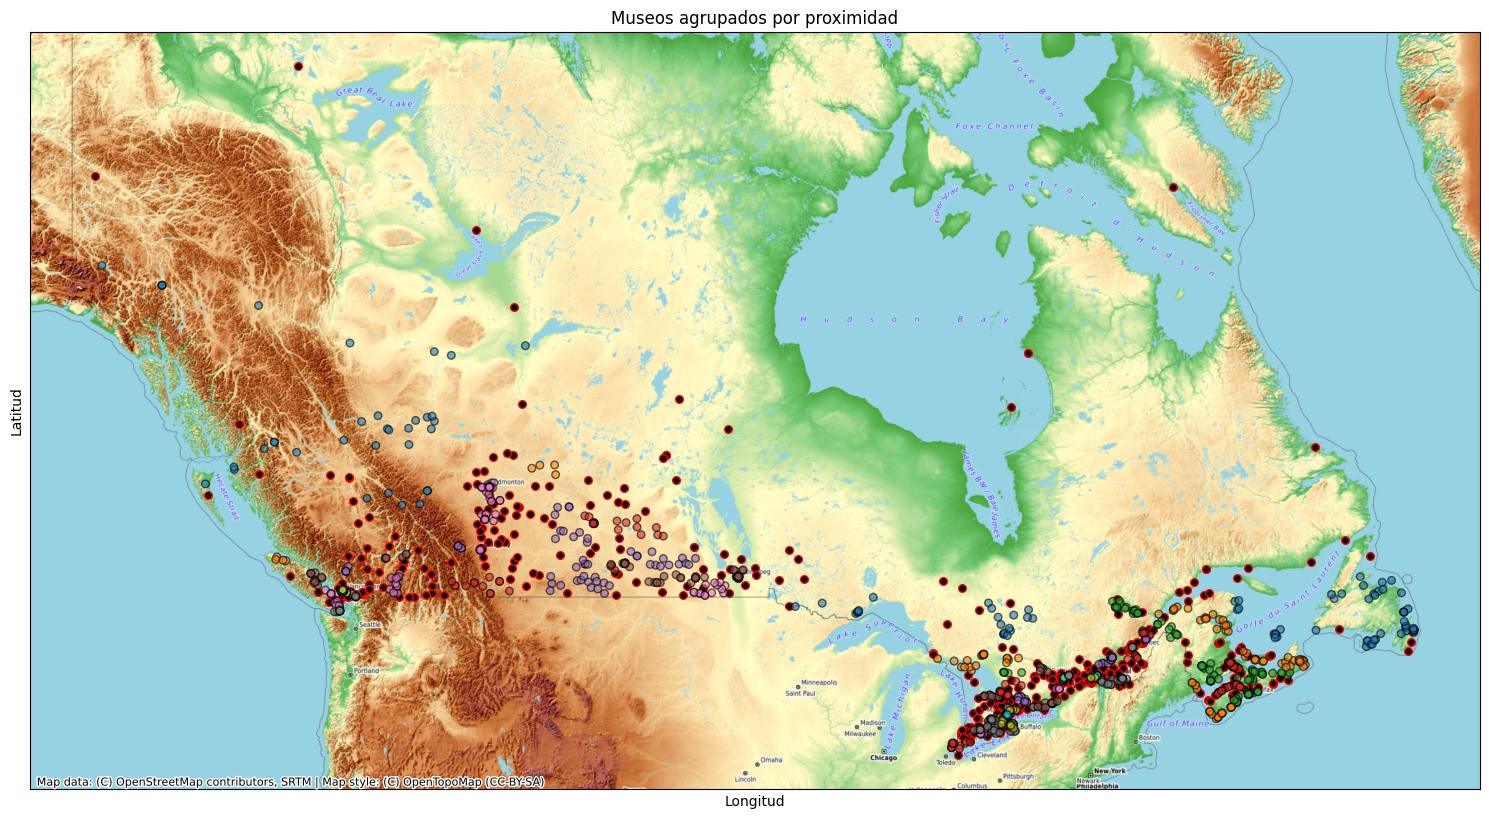

In [90]:
# Visualiza los museos agrupados por proximidad.
# 'df' es el DataFrame que contiene las coordenadas (latitud y longitud) y las etiquetas de clúster.
# El título del gráfico será 'Museos agrupados por proximidad'.

plot_clustered_locations(df, title='Museos agrupados por proximidad')

Una observación importante aquí es que los clústeres no presentan una densidad uniforme.

Por ejemplo, hay regiones donde los puntos están muy concentrados, mientras que en otras zonas están mucho más dispersos.

El algoritmo DBSCAN tiende a unir clústeres vecinos cuando están suficientemente cerca entre sí.

Veamos ahora cómo se comporta un algoritmo jerárquico basado en densidad, como HDBSCAN.

## Ahora, construiremos un modelo HDBSCAN
Como ya tenemos cargados los datos, extraidas las coordenadas y las hemos escalado. Solo queda:

- Entrenar y transformar HDBSCAN utilizando nuestras coordenadas ya escaladas.
- Extraer las etiquetas de los clústeres
- Representar los resultados sobre el mismo mapa base que antes.

Los parámetros de HDBSCAN ya están seleccionados.

#### Entrena el modelo HDBSCAN

In [76]:
min_samples = None  # Parámetro opcional que define el número mínimo de vecinos para considerar un punto como núcleo. Si se deja como None, HDBSCAN lo ajusta automáticamente.
min_cluster_size = 3  # Tamaño mínimo permitido para un clúster. En este caso, se requiere al menos 3 puntos para formar un clúster.

# Se crea una instancia del algoritmo HDBSCAN con los parámetros definidos.
# 'metric' indica que se usará la distancia euclidiana para calcular la proximidad entre puntos.
# Puedes ajustar estos parámetros según las características de tus datos.
hdb = hdbscan.HDBSCAN(min_samples=min_samples, min_cluster_size=min_cluster_size, metric='euclidean')

### Asignamos las etiquetas a nuestro dataframe de coordenadas sin escalar y mostramos el número de cada clúster de etiquetas.

In [77]:
# Asignar las etiquetas de clúster al DataFrame
# Se utiliza el método fit_predict de HDBSCAN para ajustar el modelo y obtener las etiquetas de cada punto
df['Cluster'] = hdb.fit_predict(coords_scaled)  # Otra forma de asignar las etiquetas de clúster directamente

# Mostrar el tamaño de cada clúster
# value_counts cuenta cuántos puntos hay en cada clúster, incluyendo el ruido si lo hay (etiqueta -1)
df['Cluster'].value_counts()

Cluster
-1      470
 142     45
 116     38
 83      34
 80      28
       ... 
 49       3
 57       3
 79       3
 28       3
 7        3
Name: count, Length: 151, dtype: int64

Como puedes observar, a diferencia del caso con DBSCAN, los clústeres tienen un tamaño bastante uniforme, aunque se ha identificado una cantidad considerable de ruido.

#### Representa los museos agrupados jerárquicamente sobre un mapa base de Canadá, coloreados según la etiqueta del clúster.


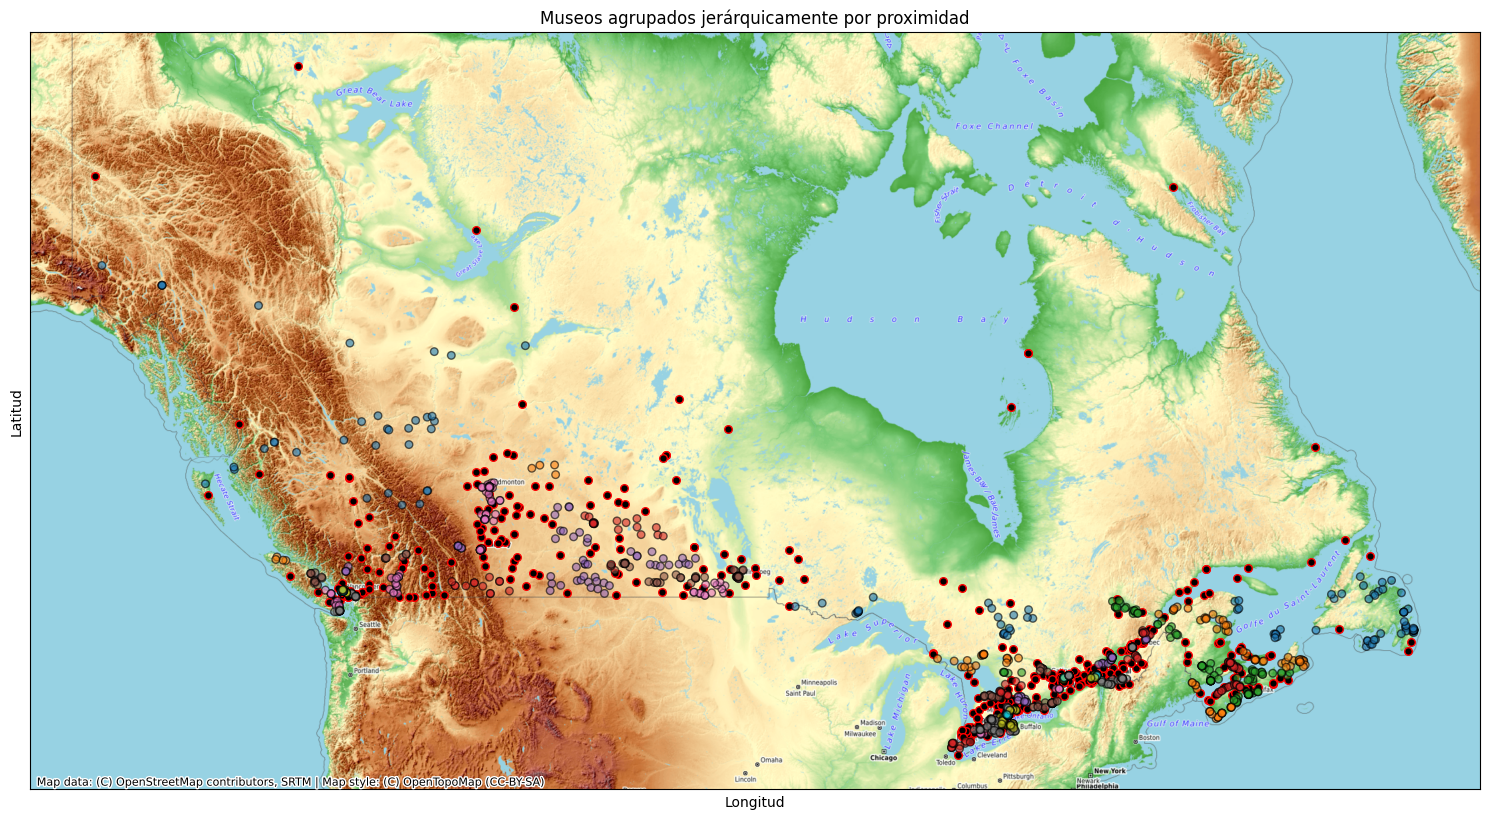

In [78]:
# Representa gráficamente los museos agrupados en función de su proximidad geográfica,
# utilizando el DataFrame `df` que contiene las ubicaciones de los museos.
# El título del gráfico será 'Museos agrupados jerárquicamente por proximidad'.
plot_clustered_locations(df, title='Museos agrupados jerárquicamente por proximidad')

### Consideraciones finales


#### ¿Qué diferencia hay entre estos resultados y los de DBSCAN?
HDBSCAN tiende a generar clústeres más homogéneos en tamaño y forma, mientras que DBSCAN puede producir conglomerados muy grandes junto con otros muy pequeños. Además, HDBSCAN es más sensible a las variaciones locales de densidad, lo que le permite separar mejor zonas densas de zonas dispersas.

#### ¿Hay realmente más puntos identificados como ruido?
Aunque visualmente puede parecer que hay más puntos etiquetados como ruido (-1), en realidad HDBSCAN es más riguroso al identificar puntos que no pertenecen a ningún clúster. Esto no significa que haya más ruido en los datos, sino que el algoritmo filtra mejor los puntos que no cumplen con los criterios de densidad.

#### ¿Se aprecian las variaciones de densidad que HDBSCAN detecta?
Sí, HDBSCAN permite ver cómo algunos clústeres están muy concentrados (alta densidad) mientras que otros están más dispersos. Esta capacidad de adaptación a diferentes densidades es una de sus principales ventajas frente a DBSCAN, que usa un único parámetro eps para todo el espacio.

#### Conclusión
Aunque el análisis es preliminar, ya se puede ver que HDBSCAN ofrece una segmentación más refinada.